# Derivative Pricing

In [1]:
#Load Package

import numpy as np
import matplotlib.pyplot as plt

## Binomial Tree

Inputs: 

$S_{ini}$ - Initial stock price
    
$T$ - time-horizon
    
$u$ - upward
    
$d$ - downward
    
$N$ - # of steps

In [21]:
def binomial_tree(S_ini, T, u, d, N):
    S = np.zeros([N + 1, N + 1])  # Underlying price
    
    for i in range(0, N + 1):
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
        
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
            
    return S

In [3]:
Stock = binomial_tree(100, 1, 1.2, 0.8, 2)
Stock

array([[100.,   0.,   0.],
       [ 80., 120.,   0.],
       [ 64.,  96., 144.]])

### Binomial Tree w/ Call Option Payoffs

Additional input: 

    K - strike price
    r - risk-free rate
    
Call Payoff:

$$\max(S_t - K; 0)$$

Risk-Neutral Probabilities and Backward induction of Call Option value

Value of call option at each node:

$$C_t = e^{-r dt} [p c^u_{t+1} + (1-p) c^d_{t+1}]$$
    
Risk neutral probability:

$$p=\frac{e^{rdt}-d}{u-d}$$

In [56]:
def binomial_call_full(S_ini, K, T, r, u, d, N):
    dt = T / N  # Define time step
    p = (np.exp(r * dt) - d) / (u - d)  # Risk neutral probabilities (probs)
    C = np.zeros([N + 1, N + 1])  # Call prices
    S = np.zeros([N + 1, N + 1])  # Underlying price
    
    for i in range(0, N + 1):
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
        C[N, i] = max(S[N, i] - K, 0)
        
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
            
    return C[0, 0], C, S, p

In [59]:
call_price, C, S, rrp = binomial_call_full(100, 80, 4, 0, 1.1, 0.8, 4)
print("Underlying Price Evolution:\n", S)
print("Call Option Payoff:\n", C)
print("Risk neutral prob (Up): ", "{:.4f}".format(rrp))
print("Call Option Price at t=0: $", "{:.2f}".format(call_price))

Underlying Price Evolution:
 [[100.     0.     0.     0.     0.  ]
 [ 80.   110.     0.     0.     0.  ]
 [ 64.    88.   121.     0.     0.  ]
 [ 51.2   70.4   96.8  133.1    0.  ]
 [ 40.96  56.32  77.44 106.48 146.41]]
Call Option Payoff:
 [[23.57925926  0.          0.          0.          0.        ]
 [ 7.84592593 31.44592593  0.          0.          0.        ]
 [ 0.         11.76888889 41.28444444  0.          0.        ]
 [ 0.          0.         17.65333333 53.1         0.        ]
 [ 0.          0.          0.         26.48       66.41      ]]
Risk neutral prob (Up):  0.6667
Call Option Price at t=0: $ 23.58


### Binomial Tree w/ Put Option Payoffs
    
Call Payoff:

$$\max(K - S_t; 0)$$

In [15]:
def binomial_put_full(S_ini, K, T, r, u, d, N):
    dt = T / N  # Define time step
    p = (np.exp(r * dt) - d) / (u - d)  # Risk neutral probs
    P = np.zeros([N + 1, N + 1])  # Call prices
    S = np.zeros([N + 1, N + 1])  # Underlying price
    
    for i in range(0, N + 1):
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
        P[N, i] = max(K - S[N, i], 0)
        
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            P[j, i] = np.exp(-r * dt) * (p * P[j + 1, i + 1] + (1 - p) * P[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
            
    return P[0, 0], P, S, p

In [10]:
put_price, P, S, rrp = binomial_put_full(100, 100, 1, 0.1, 1.2, 0.8, 1)
print("Underlying Price Evolution:\n", S)
print("Put Option Payoff:\n", P)
print("Put Option risk-neutral prob:", "{:.4f}".format(rrp))
print("Price at t=0 for Put option is $", "{:.2f}".format(put_price))

Underlying Price Evolution:
 [[100.   0.]
 [ 80. 120.]]
Put Option Payoff:
 [[ 4.29024508  0.        ]
 [20.          0.        ]]
Put Option risk-neutral prob: 0.7629
Price at t=0 for Put option is$ 4.29


### Put-Call Parity in Binomial Tree

The relationship between put and call must be:

$$C_0 + K e^{-rT} = S_0 + P_0$$

In [12]:
K = 90
r = 0
T = 10

# At t=0
t0 = round(C[0, 0] + K * np.exp(-r * T), 2) == round(S[0, 0] + P[0, 0], 2)
print(t0)

# At t=1, on path "d"
t1d = round(C[1, 0] + K * np.exp(-r * T), 2) == round(S[1, 0] + P[1,0], 2)
print(t1d)

True
True


### Delta Hedging in Binomial Tree

Additional output:

$\Delta_t$ - No. of underlying in terms of exposure

In [22]:
def european_option_delta(S_ini, K, T, r, u, d, N, opttype):
    dt = T / N  # Define time step
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([N + 1, N + 1])  # call/put prices
    S = np.zeros([N + 1, N + 1])  # underlying price
    Delta = np.zeros([N, N])  # delta
    
    for i in range(0, N + 1):
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
        
        if opttype == "C":
            C[N, i] = max(S[N, i] - K, 0) #Call option payoff
        else:
            C[N, i] = max(K - S[N, i], 0) #Put option payoff
        
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
            
            Delta[j, i] = (C[j + 1, i] - C[j + 1, i + 1]) / (
                S[j + 1, i] - S[j + 1, i + 1])
            
    return C[0, 0], C, S, Delta, p

In [23]:
price, call, S, delta, rrp = european_option_delta(100, 90, 10, 0, 1.2, 0.8, 10, "C")
print("Underlying: \n", S)
print("Call Price: \n", call)
print("Delta: \n", delta)
print("Risk neutral prob (Up): \n", "{:.4f}".format(rrp))

Underlying: 
 [[100.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [ 80.         120.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [ 64.          96.         144.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [ 51.2         76.8        115.2        172.8          0.
    0.           0.           0.           0.           0.
    0.        ]
 [ 40.96        61.44        92.16       138.24       207.36
    0.           0.           0.           0.           0.
    0.        ]
 [ 32.768       49.152       73.728      110.592      165.888
  248.832        0.           0.           0.           0.
    0.        ]
 [ 26.2144      39.3216      58.9824      88.4736     132.7104
  199.0656     298.5984       0.           0.           0.
    0.        ]
 [ 20.97152     31.45728     47.18592  

In [25]:
price, put, S, delta, rrp = european_option_delta(100, 135, 1, 0, 1.3, 0.9, 1, "P")
print("Underlying: \n", S)
print("Put Price: \n", put)
print("Delta: \n", delta)
print("Risk neutral prob (Up): \n", "{:.4f}".format(rrp))

Underlying: 
 [[100.   0.]
 [ 90. 130.]]
Put Price: 
 [[35.  0.]
 [45.  5.]]
Delta: 
 [[-1.]]
Risk neutral prob (Up): 
 0.2500


Relationship of call option price with N

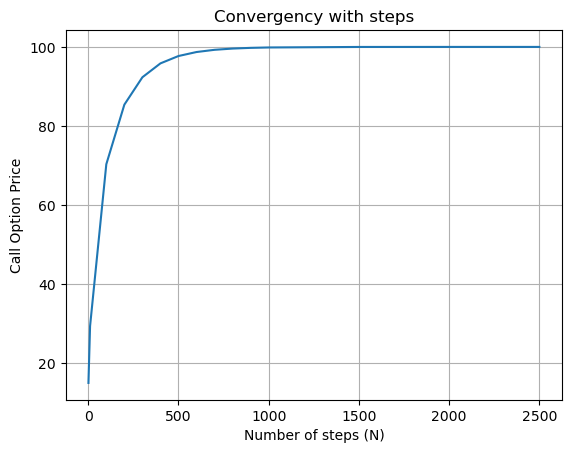

In [27]:
price_array = []
N = [1, 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500]

for n in N:
    price, call, S, delta, rrp = european_option_delta(100, 90, 1, 0, 1.2, 0.8, n, "C")
    price_array.append(price) 
    
plt.plot(N, np.array(price_array))
plt.title("Convergency with steps")
plt.xlabel("Number of steps (N)")
plt.ylabel("Call Option Price")
plt.grid(True)
plt.show()

### Adjusting u and d for Underlying Volatility

The adjustment will lead to:

$$u = \exp{(\sigma \sqrt{dt})}$$  

and

$$d = \exp{(-\sigma \sqrt{dt})}$$

In [13]:
def call_option_delta(S_ini, K, T, r, sigma, N):
    dt = T / N  # Define time step
    
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([N + 1, N + 1])  # call prices
    S = np.zeros([N + 1, N + 1])  # underlying price
    Delta = np.zeros([N, N])  # delta
    for i in range(0, N + 1):
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
        C[N, i] = max(S[N, i] - K, 0)
                
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
            
            Delta[j, i] = (C[j + 1, i + 1] - C[j + 1, i]) / (
                S[j + 1, i + 1] - S[j + 1, i])
            
    return C[0, 0], C, S, Delta

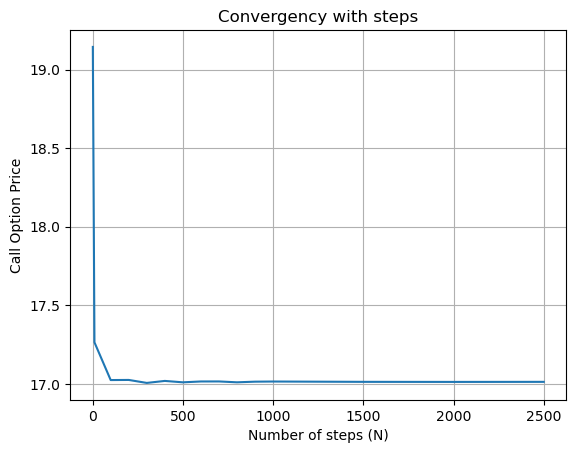

In [19]:
price_array = []
N = [1, 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500]

for n in N:
    price, call, S, delta = call_option_delta(100, 90, 1, 0, 0.3, n)
    price_array.append(price)
    
plt.plot(N, np.array(price_array))
plt.title("Convergency with steps")
plt.xlabel("Number of steps (N)")
plt.ylabel("Call Option Price")
plt.grid(True)
plt.show()

## American Options

Risk-neutral probability:

$$p = \frac{e^{r \times T} - d}{u - d}$$

NB: Delta Hedging Implemented

In [18]:
def american_option(S_ini, K, T, r, u, d, N, opttype):
    dt = T / N  # Define time step
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([N + 1, N + 1])  # call prices
    S = np.zeros([N + 1, N + 1])  # underlying price
    Delta = np.zeros([N, N])  # delta

    for i in range(0, N + 1):
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
        if opttype == "C":
            C[N, i] = max(S[N, i] - K, 0) #Call payoff
        else:
            C[N, i] = max(K - S[N, i], 0) #Put payoff

    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (
                p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i]
            )  # Computing the European option prices
            S[j, i] = (
                S_ini * (u ** (i)) * (d ** (j - i))
            )  # Underlying evolution for each node
            if opttype == "C":
                C[j, i] = max(
                    C[j, i], S[j, i] - K
                )  # Decision between the European option price and the payoff from early-exercise
            else:
                C[j, i] = max(
                    C[j, i], K - S[j, i]
                )  # Decision between the European option price and the payoff from early-exercise
            
            Delta[j, i] = (C[j + 1, i + 1] - C[j + 1, i]) / (
                S[j + 1, i + 1] - S[j + 1, i]
            )  # Computing the delta for each node

    return C[0, 0], C, S, Delta

In [63]:
#Example: American Put Option
option_price, C, S, Am_delta = american_option(45, 45, 60, 0.1, 1.2, 0.8, 60, "P")

option_price

2.517430909012516

In [59]:
#Compared to European Put Option
put_price, P, S, rrp = binomial_put_full(50, 52, 2, 0.05, 1.2, 0.8, 2)

put_price

4.1926542806038585

In [20]:
#American option delta
Am_delta

array([[-0.03469553,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.14640554, -0.01155361,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.60955935, -0.05045832, -0.00349409, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.00000004, -0.99999983, -1.00000011, ...,  0.        ,
         0.        ,  0.        ],
       [-1.00000004, -1.00000004, -1.00000004, ...,  0.        ,
         0.        ,  0.        ],
       [-1.00000042, -0.99999978, -1.00000021, ...,  0.        ,
         0.        ,  0.        ]])

### Adjusting u and d for Volatility: American Option

In [11]:
def american_option_vol(S_ini, K, T, r, sigma, N, opttype):
    dt = T / N  # Define time step
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([N + 1, N + 1])  # call prices
    S = np.zeros([N + 1, N + 1])  # underlying price

    for i in range(0, N + 1):
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
        if opttype == "C":
            C[N, i] = max(S[N, i] - K, 0)
        else:
            C[N, i] = max(K - S[N, i], 0)

    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (
                p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i]
            )  # Computing the European option prices
            S[j, i] = (
                S_ini * (u ** (i)) * (d ** (j - i))
            )  # Underlying evolution for each node
            if opttype == "C":
                C[j, i] = max(
                    C[j, i], S[j, i] - K
                )  # Decision between the European option price and the payoff from early-exercise
            else:
                C[j, i] = max(
                    C[j, i], K - S[j, i]
                )  # Decision between the European option price and the payoff from early-exercise

    return C[0, 0], C, S

In [12]:
#Ex: American call price
price, C, S = american_option_vol(100, 90, 10, 0, 0.3, 10, "C")

print(price)

39.899240766330934


In [14]:
#Compared to European call price
price, C, S, Delta = call_option_delta(100, 90, 10, 0, 0.3, 10)

print(price)

39.899240766330934


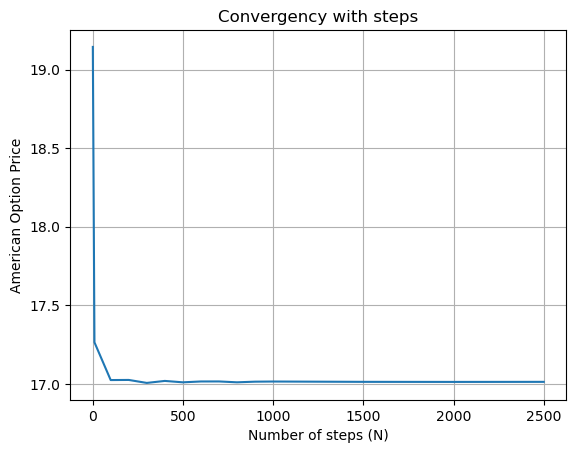

In [17]:
price_array = []
N = [1, 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500]

for n in N:
    call_price, C, S = american_option_vol(100, 90, 1, 0, 0.3, n, "C")
    price_array.append(call_price)
    
plt.plot(N, np.array(price_array))
plt.title("Convergency with steps")
plt.xlabel("Number of steps (N)")
plt.ylabel("American Option Price")
plt.grid(True)
plt.show()

### Asian option on Binomial Model (Incorrect)

In [39]:
def asian_option(S_ini, K, T, r, u, d, N, opttype="C"):
    dt = T / N  # Time step
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability
    C = np.zeros([N + 1, N + 1])  # call prices
    S = np.zeros([N + 1, N + 1])  # underlying price
    
    # compute payoff based on average 
    for i in range(N + 1):
        # Price at node (N, i)
        S_N_i = S_ini * (u ** i) * (d ** (N - i))
        
        # Compute average price along the path
        avg = 0
        for k in range(N + 1):
            if k <= i:
                S_k = S_ini * (u ** k) * (d ** (k - k))
            else:
                S_k = S_ini * (u ** i) * (d ** (k - i))
            avg += S_k
        avg /= (N + 1)
        
        # Payoff depends on average
        if opttype == "C":
            payoff = max(avg - K, 0)
        else:
            payoff = max(K - avg, 0)
        
        C[(N, i)] = payoff
        S[(N, i)] = S_N_i

    # --- Backward induction ---
    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            # Expected discounted value
            value = np.exp(-r * dt) * (p * C[(j + 1, i + 1)] + (1 - p) * C[(j + 1, i)])
            
            # Compute running average up to node (j, i)
            S_ji = S_ini * (u ** i) * (d ** (j - i))
            avg = ((j * (S_ini + S_ji) / 2) + S_ji) / (j + 1) if j > 0 else S_ji
            
            # Asian options don't have early exercise in standard form
            C[(j, i)] = value
            S[(j, i)] = S_ji

    return C[(0, 0)], C, S

In [40]:
asian_option(100, K=90, T=1, r=0, u=1.2, d=0.8, N=2, opttype="C")

(15.499999999999996,
 array([[15.5       ,  0.        ,  0.        ],
        [ 7.66666667, 23.33333333,  0.        ],
        [ 0.        , 15.33333333, 31.33333333]]),
 array([[100.,   0.,   0.],
        [ 80., 120.,   0.],
        [ 64.,  96., 144.]]))

### Monte Carlo Methods: Binomial Distribution

In [44]:
def call_option_mc(S_ini, K, T, r, sigma, N, M, opttype):
    dt = T / N  # Define time step
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([M])  # call prices
    S = np.zeros([M, N + 1])  # underlying price
    S[:, 0] = S_ini

    for j in range(0, M):
        random = np.random.binomial(
            1, p, N + 1
        )  # sample random realizations for the paths of the tree under a binomial distribution
        for i in range(1, N + 1):
            if random[i] == 1:
                S[j, i] = S[j, i - 1] * u
            else:
                S[j, i] = S[j, i - 1] * d
        
        if opttype == "C":
            C[j] = np.exp(-r * T) * max(S[j, N] - K, 0)
        else:
            C[j] = np.exp(-r * T) * max(K - S[j, N], 0)

    return S, C

In [45]:
# Prices 15000 different simulations
S, C = call_option_mc(100, 90, 1, 0, 0.3, 2500, 15000, "C") 
print(np.mean(C))

#vs Actual call option
price, C, S, delta = call_option_delta(100, 90, 1, 0, 0.3, 2500)
print(price)

16.6835694526767
17.01322570917609


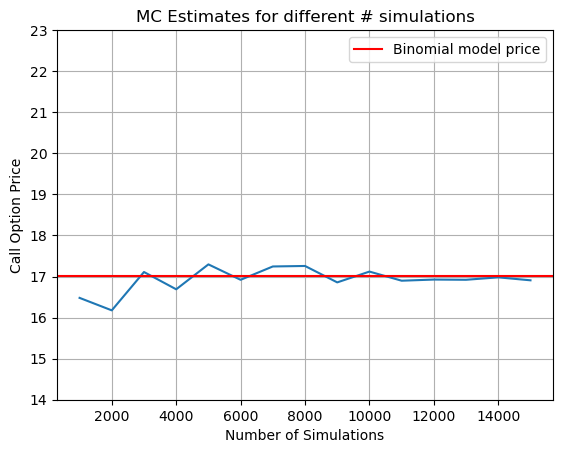

In [47]:
M = np.arange(1000, 16000, 1000)  # Different number of simulations to be considered
call_price = []

for i in range(len(M)):
    S, C = call_option_mc(100, 90, 1, 0, 0.3, 2500, M[i], "C")
    call_price.append(np.mean(C))
    
plt.plot(M, call_price)
plt.axhline(y=17.01, color="r", linestyle="-", label="Binomial model price")
plt.ylim([14, 23])
plt.title("MC Estimates for different # simulations")
plt.xlabel("Number of Simulations")
plt.ylabel("Call Option Price")
plt.grid(True)
plt.legend()
plt.show()

In [48]:
def asian_option_mc(S_ini, K, T, r, sigma, N, M):
    dt = T / N  # Define time step
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    Asian = np.zeros([M])  # Asian prices
    S = np.zeros([M, N + 1])  # underlying price
    S[:, 0] = S_ini

    for j in range(0, M):
        random = np.random.binomial(1, p, N + 1)
        Total = S_ini
        
        for i in range(1, N + 1):
            if random[i] == 1:
                S[j, i] = S[j, i - 1] * u
                Total = Total + S[j, i]
            else:
                S[j, i] = S[j, i - 1] * d
                Total = Total + S[j, i]

        Asian[j] = np.exp(-r * T) * max(Total / (N + 1) - K, 0)

    return S, Asian

In [49]:
S, Asian = asian_option_mc(100, 90, 1, 0, 0.3, 2500, 10000)
print(np.mean(Asian))

12.315639829209502


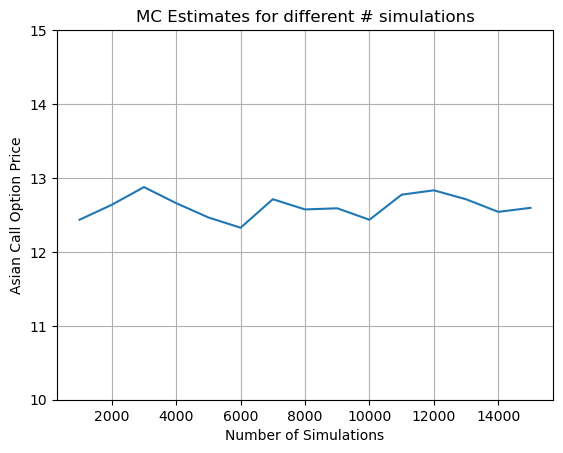

In [50]:
M = np.arange(1000, 16000, 1000)
asian_price = []

for i in range(len(M)):
    S, Asian = asian_option_mc(100, 90, 1, 0, 0.3, 2500, M[i])
    asian_price.append(np.mean(Asian))
    
plt.plot(M, asian_price)
plt.ylim([10, 15])
plt.title("MC Estimates for different # simulations")
plt.xlabel("Number of Simulations")
plt.ylabel("Asian Call Option Price")
plt.grid(True)
plt.show()

## Trinomial Tree

In [72]:
def _gen_stock_vec(nb, up): #nb - No. of periods; up - up movements
    #Initialize
    s0 = 100 #Initial underlying price
    down = 1 / up #Down movement to force a "recombining tree"
    
    vec_u = up * np.ones(nb)
    np.cumprod(vec_u, out=vec_u)  # Computing u, u^2, u^3....u^nb

    vec_d = down * np.ones(nb)
    np.cumprod(vec_d, out=vec_d)  # Computing d, d^2, d^3....d^nb

    res = np.concatenate(
        (vec_d[::-1], [1.0], vec_u)
    )  # putting together the last period tree underlyings
    
    res *= s0 #Multiply all by s0
    
    return res

In [73]:
# Calc. underlying payoff for each period
nb = 6

for i in range(1, nb + 1):
    vec_stock = _gen_stock_vec(nb - i, 1.2)
    print(nb - i, ' = ', vec_stock)

5  =  [ 40.1877572   48.22530864  57.87037037  69.44444444  83.33333333
 100.         120.         144.         172.8        207.36
 248.832     ]
4  =  [ 48.22530864  57.87037037  69.44444444  83.33333333 100.
 120.         144.         172.8        207.36      ]
3  =  [ 57.87037037  69.44444444  83.33333333 100.         120.
 144.         172.8       ]
2  =  [ 69.44444444  83.33333333 100.         120.         144.        ]
1  =  [ 83.33333333 100.         120.        ]
0  =  [100.]


## Match Volatility in Trinomial Tree

In [82]:
def _gen_stock_vec(nb, h):
    #T = 1 
    #h = T/nb #This is no. of time-step in each period (i.e. dt)
    s0 = 100
    sigma = 0.5
    up = np.exp(sigma * np.sqrt(2 * h))
    down = 1 / up  # down movement to force a "recombining tree"
    
    vec_u = up * np.ones(nb)
    np.cumprod(vec_u, out=vec_u)  # Computing u, u^2, u^3....u^nb

    vec_d = down * np.ones(nb)
    np.cumprod(vec_d, out=vec_d)  # Computing d, d^2, d^3....d^nb

    res = np.concatenate(
        (vec_d[::-1], [1.0], vec_u)
    )  # putting together the last period tree underlyings
    
    res *= s0
    
    return res

In [81]:
#Example

nb = 3 #3-steps in 1 "year" (assuming all parameters annualized)
T = 1
h = T/nb

for i in range(1, nb + 1):
    vec_stock = _gen_stock_vec(nb - i, h)
    print(nb - i, " = ", vec_stock)


-1.1689943799088078
2  =  [ 44.19773772  66.48137914 100.         150.41805885 226.25592428]
-1.1689943799088078
1  =  [ 66.48137914 100.         150.41805885]
-1.1689943799088078
0  =  [100.]


Call Option Matching volatility

In [83]:
# The only input is No. of steps for the tree, N.
def price(nb_steps, opttype):  
    # Define parameters
    r = 0
    sigma = 0.5
    T = 1
    K = 110
    h = T / nb_steps  # i.e. 'dt' 
    discount = np.exp(-r * h)  # Define discount factor for simplicity

    # Define risk-neutral probabilities:
    pu = ((np.exp(r * h / 2) - np.exp(-sigma * np.sqrt(h / 2)))
        / (np.exp(sigma * np.sqrt(h / 2)) - np.exp(-sigma * np.sqrt(h / 2)))
    ) ** 2
    
    pd = (
        (-np.exp(r * h / 2) + np.exp(sigma * np.sqrt(h / 2)))
        / (np.exp(sigma * np.sqrt(h / 2)) - np.exp(-sigma * np.sqrt(h / 2)))
    ) ** 2
    
    pm = 1 - pu - pd
    
    #print(pu, pd, pm)
    
    # Underlying evolution 
    s = _gen_stock_vec(nb_steps, h)
    #print("stock", s)

    # Define Payoff (in this case, European Call Option)
    if opttype == "C":
        final_payoff = np.maximum(s - K, 0)
    else:
        final_payoff = np.maximum(K - s, 0)
    nxt_vec_prices = final_payoff

    # Proceed with iterations for the calculation of payoffs
    for i in range(1, nb_steps + 1):
        vec_stock = _gen_stock_vec(nb_steps - i, h)
        expectation = np.zeros(vec_stock.size)

        for j in range(expectation.size):
            tmp = nxt_vec_prices[j] * pd
            tmp += nxt_vec_prices[j + 1] * pm
            tmp += nxt_vec_prices[j + 2] * pu

            expectation[j] = tmp
            
        # Discount option payoff!
        nxt_vec_prices = discount * expectation
    
    # Only 'return' the expected discounted value of option at t=0, the price of call option!
    return nxt_vec_prices[0]  

In [84]:
#Example

option_price = price(100, "C")

print("European Call Price:", option_price)

European Call Price: 16.115031285941384


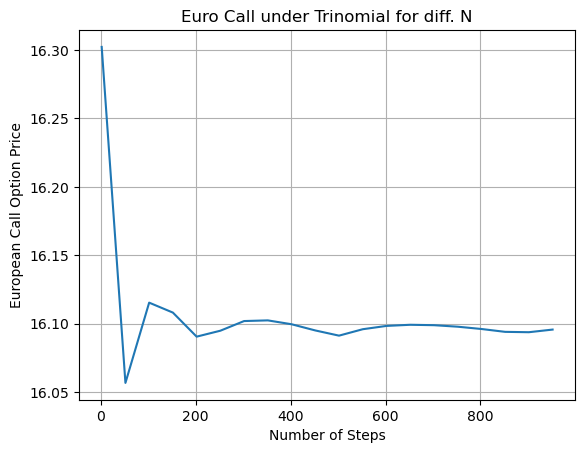

In [60]:
N = np.arange(2, 1000, 50)
prices = []

for i in N:
    prices.append(price(i, "C"))
    
plt.plot(N, prices)
plt.title("Euro Call under Trinomial for diff. N")
plt.xlabel("Number of Steps")
plt.ylabel("European Call Option Price")
plt.grid(True)
plt.show()

# Object-Oriented Programming in Trinomial Tree

In [61]:
class TrinomialModel(object):  # Define our 'class' --> Trinomial Model!
    
    # 1: method to initialize our `TrinomialModel` algorithm!
    def __init__(self, S0, r, sigma, mat):
        self.__s0 = S0
        self.__r = r
        self.__sigma = sigma
        self.__T = mat
        
    # 2: build a method (function) to compute risk-neutral probabilities!
    def __compute_probs(self):
        self.__pu = ( (np.exp(self.__r * self.__h / 2)
                - np.exp(-self.__sigma * np.sqrt(self.__h / 2)))
            / (np.exp(self.__sigma * np.sqrt(self.__h / 2))
                - np.exp(-self.__sigma * np.sqrt(self.__h / 2))) ) ** 2
        
        self.__pd = ( (-np.exp(self.__r * self.__h / 2)
                + np.exp(self.__sigma * np.sqrt(self.__h / 2)))
            / (np.exp(self.__sigma * np.sqrt(self.__h / 2))
                - np.exp(-self.__sigma * np.sqrt(self.__h / 2)))) ** 2
        
        self.__pm = 1 - self.__pu - self.__pd
        
        assert 0 <= self.__pu <= 1.0, "p_u should lie in [0, 1] given %s" % self.__pu
        assert 0 <= self.__pd <= 1.0, "p_d should lie in [0, 1] given %s" % self.__pd
        assert 0 <= self.__pm <= 1.0, "p_m should lie in [0, 1] given %s" % self.__pm

    # 3: this method checks whether given parameters are alright and have a 'recombining tree'!
    def __check_up_value(self, up):
        if up is None:
            up = np.exp(self.__sigma * np.sqrt(2 * self.__h))

        assert up > 0.0, "up should be non negative"

        down = 1 / up

        assert down < up, "up <= 1. / up = down"

        self.__up = up
        self.__down = down
        
    # 4: This method computes underlying stock price path
    def __gen_stock_vec(self, nb):
        vec_u = self.__up * np.ones(nb)
        np.cumprod(vec_u, out=vec_u)

        vec_d = self.__down * np.ones(nb)
        np.cumprod(vec_d, out=vec_d)

        res = np.concatenate((vec_d[::-1], [1.0], vec_u))
        res *= self.__s0

        return res
    
    # 5: declare a Payoff method to be completed afterwards depending on the instrument we are pricing!
    def payoff(self, stock_vec):
        raise NotImplementedError()

    # 6: compute current prices!
    def compute_current_price(self, crt_vec_stock, nxt_vec_prices):
        expectation = np.zeros(crt_vec_stock.size)
        
        for i in range(expectation.size):
            tmp = nxt_vec_prices[i] * self.__pd
            tmp += nxt_vec_prices[i + 1] * self.__pm
            tmp += nxt_vec_prices[i + 2] * self.__pu

            expectation[i] = tmp

        return self.__discount * expectation
    
    # 7: Option pricing!
    def price(self, nb_steps, up=None):
        assert nb_steps > 0, "nb_steps shoud be > 0"

        nb_steps = int(nb_steps)

        self.__h = self.__T / nb_steps
        self.__check_up_value(up)
        self.__compute_probs()

        self.__discount = np.exp(-self.__r * self.__h)

        final_vec_stock = self.__gen_stock_vec(nb_steps)
        final_payoff = self.payoff(final_vec_stock)
        nxt_vec_prices = final_payoff

        for i in range(1, nb_steps + 1):
            vec_stock = self.__gen_stock_vec(nb_steps - i)
            nxt_vec_prices = self.compute_current_price(vec_stock, nxt_vec_prices)

        return nxt_vec_prices[0]

In [62]:
#Define initialization and payoff methods for new class "Call" within TrinomialModel
class TrinomialCall(TrinomialModel):
    
    def __init__(self, S0, r, sigma, mat, K):
        super(TrinomialCall, self).__init__(S0, r, sigma, mat)
        self.__K = K

    def payoff(self, s):
        return np.maximum(s - self.__K, 0.0)

In [63]:
class TrinomialPut(TrinomialModel):
    
    def __init__(self, S0, r, sigma, mat, K):
        super(TrinomialPut, self).__init__(S0, r, sigma, mat)
        self.__K = K

    def payoff(self, s):
        return np.maximum(self.__K - s, 0.0)

In [71]:
#Can implement trinomial model pricing for European call option
tree = TrinomialCall(50.0, 0.0, 0.5, 1.0, 130.0)
#tree = TrinomialPut(100.0, 0.0, 0.3, 1.0, 90.0)

print(tree.price(100))

0.42188922677918306
